In [1]:
import torch
import numpy as np
import scipy
import libsvm
import libsvmdata
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
font =  {
            'family': 'DejaVu Sans',
            'weight': 'normal',
            'size'  :  14
        }

matplotlib.rc('font', **font)
%config InlineBackend.figure_formats = ['svg']

In [2]:
X, y = libsvmdata.fetch_libsvm('a1a')
X.shape, y.shape
try:
    X = torch.tensor(X)
except Exception:
    X = torch.tensor(X.todense())
y = torch.tensor(y)

In [3]:
from decentralized.topologies import Topologies
from oracles.binary_svc_oracle import BinarySVC
from oracles.l1_regression_oracle import L1RegressionOracle
from methods.centralized_gd import CentralizedGradientDescent
from methods.decentralized_gd import DecentralizedGradientDescent
from methods.ZOSADOM import ZOSADOM
from methods.decentralized_cs import DecentralizedCommunicationSliding

In [4]:
import pickle


def get_oracles(X, y, n, grad_type):
    result = []
    start = 0
    step = X.shape[0] // n
    for tmp in range(n):
        result.append(BinarySVC(X[start:start + step], y[start:start + step], grad_type=grad_type))
        start += step
    return result


def to_list_of_loss(logs, name=None):
    result = []
    for el in logs:
        result.append(el["loss"])
    if name is not None:
        with open(name + '.pkl', 'wb') as f:
            pickle.dump(result, f)
    return np.array(result)

In [35]:
max_iter = 50
topology = "ring-star"
n_nodes = 10

In [44]:
%%time
optimizer = CentralizedGradientDescent(
    get_oracles(X, y, n_nodes, "grad"),
    Topologies(n_nodes, topology, "gossip-laplacian", n_graphs=30),
    0.01,
    max_iter
)
optimizer.run(log=True)
f_star = np.min(to_list_of_loss(optimizer.logs, name=f'for_img/l1_DCS_{topology}_{n_nodes}'))

CPU times: user 1.61 s, sys: 207 ms, total: 1.82 s
Wall time: 435 ms


In [45]:
%%time
optimizer = DecentralizedCommunicationSliding(
    get_oracles(X, y, n_nodes, "grad"),
    Topologies(n_nodes, topology, "gossip-laplacian", n_graphs=30),
    max_iter
)
optimizer.run(log=True)
dcs_loss = to_list_of_loss(optimizer.logs, name=f'for_img/l1_DCS_{topology}_{n_nodes}')

CPU times: user 1min 42s, sys: 398 ms, total: 1min 43s
Wall time: 31.6 s


In [46]:
%%time
optimizer = DecentralizedGradientDescent(
    get_oracles(X, y, n_nodes, "grad"),
    Topologies(n_nodes, topology, "mixing-laplacian",  n_graphs=30),
    0.1,
    max_iter
)
optimizer.run(log=True)
dgd_loss = to_list_of_loss(optimizer.logs, name=f'for_img/l1_DGD_{topology}_{n_nodes}')

CPU times: user 1.77 s, sys: 199 ms, total: 1.97 s
Wall time: 474 ms


In [47]:
f_star = min(f_star, np.min(dcs_loss), np.min(dgd_loss))

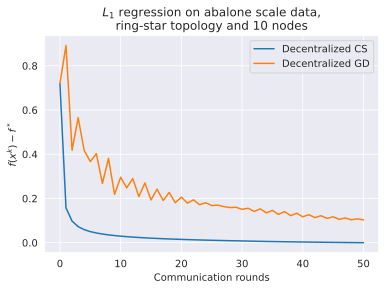

In [52]:
plt.plot(np.arange(max_iter + 1), dcs_loss - f_star, label="Decentralized CS")
plt.plot(np.arange(max_iter + 1), dgd_loss - f_star, label="Decentralized GD")
plt.title(r"$L_1$ regression on abalone scale data," + f"\n{topology} topology and {n_nodes} nodes")
plt.xlabel("Communication rounds")
plt.ylabel(r"$f(x^k) - f^*$")
plt.legend()
plt.savefig(f"img/l1_regression_abalone_scale_{topology}_{n_nodes}.svg")